## Initial CLIP Model Setup

There's some setup stuff we need to take care of first. These packages are installed using pip magic, so we shouldn't need to run this cell again (it lowkey takes a while)

In [ ]:
# 1 · GPU-enabled PyTorch + torchvision, compiled for CUDA 12.6
%pip install --quiet "torch==2.7.*" "torchvision==0.22.*" \
                 --index-url https://download.pytorch.org/whl/cu126

# 2 · CLIP and its tiny helpers
%pip install --quiet ftfy regex tqdm \
                 git+https://github.com/openai/CLIP.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.0/867.0 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 121.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8

In [ ]:
import torch, clip
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

print("torch", torch.__version__, "| CUDA OK? ", torch.cuda.is_available())

#####################################################
#    CHANGE THIS TO DEVICE="CUDA" WHEN TRAINING!    #
#####################################################
device = "cuda"


model_vit, vit_preprocess = clip.load("ViT-B/32", device=device)
print("Loaded CLIP ViT on", next(model_vit.parameters()).device)
model_resnet, resnet_preprocess = clip.load("RN50", device=device)
print("Loaded CLIP ResNet on", next(model_resnet.parameters()).device)


torch 2.7.0+cu126 | CUDA OK?  True


100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 61.3MiB/s]


Loaded CLIP ViT on cuda:0


100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 53.6MiB/s]


Loaded CLIP ResNet on cuda:0


In [ ]:
vit_device = next(model_vit.parameters()).device
resnet_device = next(model_resnet.parameters()).device

Here's the plan:
- Import the CLIP model, inspect it, choose a layer near the end.
- Write my own code for a very simple SAE (using linear layers) and my own training loop

In [ ]:
print(model_resnet)

CLIP(
  (visual): ModifiedResNet(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
     

In [ ]:
print(model_vit)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Test the model by handing it some images, making sure it runs.

In [ ]:
dataset = torchvision.datasets.CIFAR10(
    root="data", train=True, download=True # NOTE THAT THIS IS THE TRAIN DATASET
)

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


In [ ]:
batch_imgs_vit = torch.stack([
    vit_preprocess(img)
    for img, _ in [dataset[i] for i in range(64)] # takes in a mini batch of 64 images
]).to(vit_device)

outs_vit = model_vit.encode_image(batch_imgs_vit)

In [ ]:
batch_imgs_resnet = torch.stack([
    resnet_preprocess(img) # img is already a PIL Image
    for img, _ in [dataset[i] for i in range(64)]
]).to(resnet_device)

outs_resnet = model_resnet.encode_image(batch_imgs_resnet)

## SAE Setup

Define the sparse autoencoder. For starters, we can just have a single linear layer on either side of a latent space. Regularization will be taken care of in defining training/loss.

For help figuring out the exact details I referenced ChatGPT, [GeeksForGeeks](https://www.geeksforgeeks.org/sparse-autoencoders-in-deep-learning/), this [random notebook](https://colab.research.google.com/github/rastringer/unraveling_superposition/blob/main/sparse_autoencoders) I found through Google, this [tutorial](https://colab.research.google.com/drive/1DSqMihSkocF4WtLtazpIpZoUzrlu3Vdb#scrollTo=AVKobnx_vw-r) from LessWrong. Note that the LessWrong tutorial allows for the model to have biases; this may be interesting or it may not be idk.

**TODO**: How has previous work structured the autoencoder? What seems to work well?


In [ ]:
class LinearSAE(torch.nn.Module):
  def __init__(self, in_size, latent_size):
    super().__init__()
    self.encode = torch.nn.Linear(in_size, latent_size, bias = False)
    self.decode = torch.nn.Linear(latent_size, in_size, bias = False)
    # Should I tie the weights? in theory, they should be identical?

  def forward(self, x):
    latent_activations = torch.relu(self.encode(x))
    x_pred = self.decode(latent_activations)
    return x_pred, latent_activations


Instantiate SAEs, one for the ViT and one for the ResNet:

In [ ]:
sae_vit  = LinearSAE(in_size=768,  latent_size=3072).to(vit_device) # goes in after LayerNorm(768)
sae_rn50 = LinearSAE(in_size=1024, latent_size=4096).to(resnet_device) # goes in after AttnPool (projecting down to 1024)

In [ ]:
## Test the SAEs
print("test")

test_in_vit = torch.zeros((5, 768)).to(vit_device)
test_in_resnet = torch.zeros((5, 1024)).to(resnet_device)

test_out_vit, latents_vit = sae_vit(test_in_vit)
test_out_resnet, latents_resnet = sae_rn50(test_in_resnet)

print(test_out_vit.shape, test_out_resnet.shape)
print(latents_vit.shape, latents_resnet.shape)

test
torch.Size([5, 768]) torch.Size([5, 1024])
torch.Size([5, 3072]) torch.Size([5, 4096])


Hook the transformer - This defines a "callback" using `torch.nn.modules.module.register_module_forward_hook` (docs info [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.modules.module.register_module_forward_hook.html) though not particularly helpful) so that pytorch knows that, whenever it runs the forward pass, to run our hook function and save the input. We'll use this to assemble our training data.

In [ ]:
# Empty activations dictionary
activations = {}

def define_hook_extract_activations(name):
  # the function returns our hook function
  # tailored to whatever name we want.

  def hook(model, input, output):
    activations[name] = output
    # print("extracted activations for", name)

  return hook

# Define the layer we want to hook
vit_hook_layer = model_vit.visual.ln_post
resnet_hook_layer = model_resnet.visual.attnpool

# Check: Have we actually gotten the layer we want?
print(vit_hook_layer)
print(resnet_hook_layer)

# Removes hooks if they already exist.
# Should hopefully prevent us from having any duplicate hooks.

try:
  handle_vit.remove()
  handle_resnet.remove()
except:
  pass

# The register_forward_hook method registers the hook on the nn.Module object
# (in this case the LayerNorm and the AttentionPool2d) and then returns a 'handle'
# object that can we can use to remove the hook (as we do at the end of this cell)
handle_vit = vit_hook_layer.register_forward_hook(define_hook_extract_activations("vit_hook"))
handle_resnet = resnet_hook_layer.register_forward_hook(define_hook_extract_activations("resnet_hook"))

# Test with a forward pass of 0s to see if we're getting the activations
dummy_in_vit = torch.zeros((1, 3, 224, 224)).to(vit_device)
dummy_in_resnet = torch.zeros((1, 3, 224, 224)).to(resnet_device)
dummy_out = model_vit.encode_image(dummy_in_vit)
dummy_out = model_resnet.encode_image(dummy_in_resnet)

# Do we have activations from both layers?
print([activations[key].shape for key in activations.keys()])

LayerNorm((768,), eps=1e-05, elementwise_affine=True)
AttentionPool2d(
  (k_proj): Linear(in_features=2048, out_features=2048, bias=True)
  (q_proj): Linear(in_features=2048, out_features=2048, bias=True)
  (v_proj): Linear(in_features=2048, out_features=2048, bias=True)
  (c_proj): Linear(in_features=2048, out_features=1024, bias=True)
)
[torch.Size([1, 768]), torch.Size([1, 1024])]


Run a test using our previously-defined batch:

In [ ]:
# This is a memory-intensive operation; Colab will crash if you try to run it on a CPU.

with torch.no_grad():
  outs_vit = model_vit.encode_image(batch_imgs_vit)
  outs_resnet = model_resnet.encode_image(batch_imgs_resnet)

print([activations[key].shape for key in activations.keys()])

[torch.Size([64, 768]), torch.Size([64, 1024])]


## Overfitting the SAE on a batch

Training loop:
1. Run an image batch through the CLIP model, therefore saving activations in activations["vit_hook"] (should be [N x dim])
2. forward pass on the SAE, evaluating loss
3. step the optimizer

In [ ]:
loss_criterion = torch.nn.MSELoss()
l1 = 1e-3
optimizer = torch.optim.Adam(sae_vit.parameters(), lr=2e-4)

loss_history = []
vit_batches = [batch_imgs_vit for i in range(30)]

# recall: dataset was defined above.

for batch in vit_batches:
  # Zero the grad
  optimizer.zero_grad()

  dummy_out = model_vit.encode_image(batch)
  sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)

  sae_preds, latents = sae_vit(sae_y)

  loss = loss_criterion(sae_preds, sae_y) + l1 * latents.abs().mean()
  loss_history.append(loss)

  loss.backward()
  optimizer.step()

loss_history = [item.item() for item in loss_history]
print(loss_history)

[1.0535075664520264, 0.8543853759765625, 0.7038164138793945, 0.5899651646614075, 0.5109592080116272, 0.46376320719718933, 0.4367978274822235, 0.41483351588249207, 0.38932105898857117, 0.36076492071151733, 0.33335748314857483, 0.3102147877216339, 0.2919303774833679, 0.2773667871952057, 0.26486489176750183, 0.2531644403934479, 0.24169911444187164, 0.23041455447673798, 0.21946316957473755, 0.2090066522359848, 0.19914089143276215, 0.18977510929107666, 0.18068119883537292, 0.1716856062412262, 0.1627567857503891, 0.15405629575252533, 0.14583180844783783, 0.13828054070472717, 0.13143306970596313, 0.12516248226165771]


Plot the loss history:

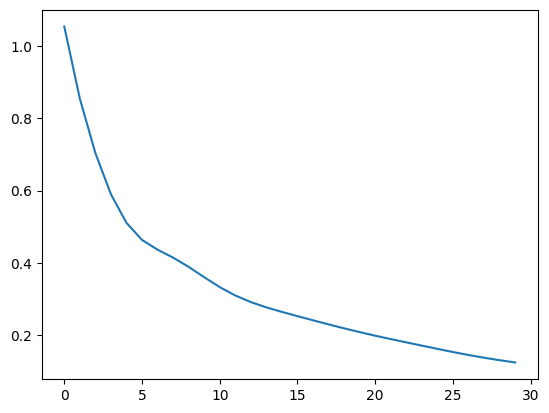

In [ ]:
plt.plot(range(len(loss_history)), loss_history)
plt.show()

## An actual training loop

Loaded model on device  cuda:0
Loaded SAE on device  cuda:0
batch  0  of  391
batch  1  of  391
batch  2  of  391
batch  3  of  391
batch  4  of  391
batch  5  of  391
batch  6  of  391
batch  7  of  391
batch  8  of  391
batch  9  of  391
batch  10  of  391
batch  11  of  391
batch  12  of  391
batch  13  of  391
batch  14  of  391
batch  15  of  391
batch  16  of  391
batch  17  of  391
batch  18  of  391
batch  19  of  391
batch  20  of  391
batch  21  of  391
batch  22  of  391
batch  23  of  391
batch  24  of  391
batch  25  of  391
batch  26  of  391
batch  27  of  391
batch  28  of  391
batch  29  of  391
batch  30  of  391
batch  31  of  391
batch  32  of  391
batch  33  of  391
batch  34  of  391
batch  35  of  391
batch  36  of  391
batch  37  of  391
batch  38  of  391
batch  39  of  391
batch  40  of  391
batch  41  of  391
batch  42  of  391
batch  43  of  391
batch  44  of  391
batch  45  of  391
batch  46  of  391
batch  47  of  391
batch  48  of  391
batch  49  of  391


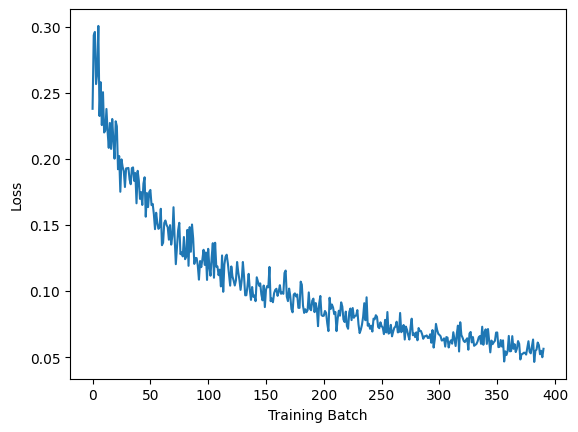

In [ ]:
## =================================================================================== ##
## TODO: take the previous cell's code and modify it so that it can properly work
##
##  Updates to make:
##     - Turn off requires_grad when you do the forward pass on vit itself
##     - Do proper SGD, rather than overfitting on a dataset of 64 images
##     - Use the native pytorch structures (e.g. dataloader) to optimize training
##
## =================================================================================== ##

from torch.utils.data import Subset

## ===== WHICH MODELS? ===== ##

sae_to_train = sae_vit
clip_to_train_on = model_vit


## =====  HYPERPARAMETERS   ===== ##

batch_size = 16
learning_rate = 3e-4
l1_strength = 3e-3
num_epochs = 1

# subset_division tells dataloader what fraction of the train dataset to use
# (useful for testing a smaller training run)
subset_division = 8

loss_criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(sae_to_train.parameters(), lr=learning_rate)

## ===== DATA PREPROCESSING ===== ##

train_dataset = torchvision.datasets.CIFAR10(
    root="data", train=True, download=True, transform=vit_preprocess
    # runs the preprocess() function as a transform!     ^^^^
)

subset_size = len(train_dataset) // subset_division
indices = list(range(subset_size))
subset_train_dataset = Subset(train_dataset, indices)

train_loader_batches = torch.utils.data.DataLoader(
    subset_train_dataset,
    batch_size = batch_size,
    shuffle = True,
    # could use workers, pin memory, etc. but idk what they do
)

## ===== SET UP MODELS AND ENSURE CORRECT DEVICES ===== ##
clip_to_train_on.eval().requires_grad_(False)
clip_device = next(clip_to_train_on.parameters()).device

print("Loaded model on device ", clip_device)
print("Loaded SAE on device ", next(sae_to_train.parameters()).device)
# TODO: ADD CHECK TO MAKE SURE THE HOOKS ARE IN THERE AND MOVE SAE TO SAME DEVICE AS CLIP


## ========== TRAINING LOOP ========== ##

loss_history = []

for epoch in range(num_epochs):
  i=0

  # _ is the img labels. We don't care about them
  for img_batch, _ in train_loader_batches:

    print("batch ", i, " of ", len(train_loader_batches))
    i += 1
    img_batch = img_batch.to(clip_device)

    # run the forward pass (grad should be off)
    dummy_out = clip_to_train_on.encode_image(img_batch)

    # Get input data and run preds
    sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)
    sae_preds, latents = sae_vit(sae_y)

    # Define loss with l1 regularization (needs to be how strong?)
    loss = loss_criterion(sae_preds, sae_y) + l1_strength * latents.abs().mean()
    loss_history.append(loss)

    # Compute grads and step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print(f"epoch {epoch+1}/{num_epochs}  •  avg-loss = {sum(loss_history[-len(train_loader_batches):]) / len(train_loader_batches):.4f}")

loss_history = [item.item() for item in loss_history]
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel("Training Batch")
plt.ylabel("Loss")
plt.show()

Test on validation set:

In [ ]:
## TODO ##

## Evaluating Sparsity

In [ ]:
def population_sparsity(latent_activations, threshold=1e-6):
  active = (latent_activations > threshold).astype(float)
  return active.mean(axis=1).mean()

def lifetime_sparsity(latent_activations, threshold=1e-6):
  active = (latent_activations > threshold).astype(float)
  sparsity_per_unit = active.mean(axis=0)
  return sparsity_per_unit, float(sparsity_per_unit.mean())

Use one big batch of all the data

In [ ]:
subset_size = len(train_dataset) // 10
indices = list(range(subset_size))
subset = Subset(train_dataset, indices)

big_loader = torch.utils.data.DataLoader(
    subset,
    batch_size=subset_size,
    shuffle=False
)
all_inputs, all_labels = next(iter(big_loader))
print(all_inputs.shape)

torch.Size([5000, 3, 224, 224])


In [ ]:
N = all_inputs.size(0)
all_inputs = all_inputs.to(clip_device)

Evaluate population and lifetime sparsity

In [ ]:
sae_vit.eval()
with torch.no_grad():
  sae_y = activations["vit_hook"].type(sae_vit.encode.weight.dtype)
  sae_preds, latent = sae_vit(sae_y)
  latent = torch.relu(latent)
latent = latent.cpu().numpy()
pop_sparse = population_sparsity(latent)
sparsity_per_unit, avg_life_sparse = lifetime_sparsity(latent)

#uncomment if want to print out individual unit inactivity
#print("Lifetime sparsity per unit:")
#for j, sp in enumerate(sparsity_per_unit):
#    print(f"  Unit {j:2d}: {100*sp:.1f}% inactive")

print(f"Mean lifetime sparsity: {100*avg_life_sparse:.1f}%")
print(f"Population sparsity: {pop_sparse}")

Mean lifetime sparsity: 72.4%
Population sparsity: 0.7236002604166667


Plot lifetime sparsity distribution

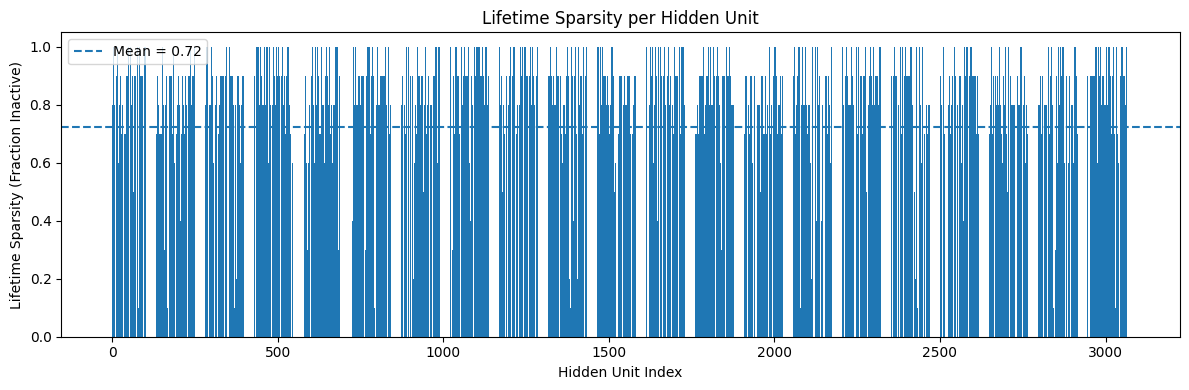

In [ ]:
H = len(sparsity_per_unit)
unit_indices = np.arange(H)

plt.figure(figsize=(12, 4))
plt.bar(unit_indices, sparsity_per_unit)
plt.axhline(sparsity_per_unit.mean(), linestyle='--',
            label=f"Mean = {sparsity_per_unit.mean():.2f}")
plt.xlabel("Hidden Unit Index")
plt.ylabel("Lifetime Sparsity (Fraction Inactive)")
plt.title("Lifetime Sparsity per Hidden Unit")
plt.legend()
plt.tight_layout()
plt.show()

ValueError: x and y must be the same size

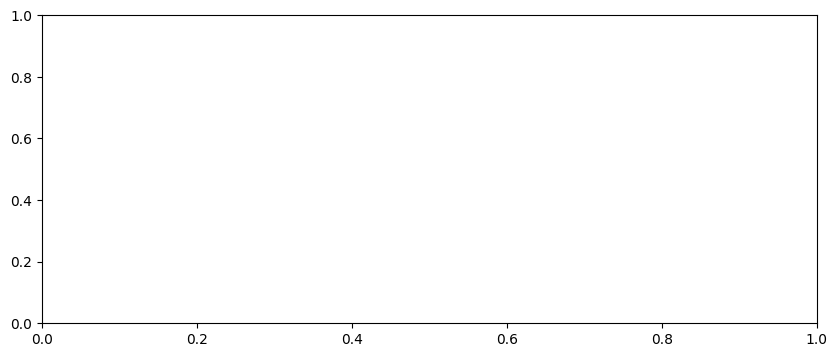

In [ ]:
plt.figure(figsize=(10,4))
d=3072
plt.scatter(np.arange(d), lifetime_sparsity, s=5)
plt.hlines(lifetime_sparsity.mean(), 0, d-1, linestyles='dashed', label=f"Mean = {lifetime_sparsity.mean():.2f}")
plt.xlabel("Hidden unit index")
plt.ylabel("Lifetime sparsity (frac inactive)")
plt.legend()
plt.show()

# Top K Activated Images


Hook for hidden states (necessary for open ai clip models, not needed for huggingface)

In [ ]:
def top_k_images(sae_model, dataset, device, k=5, batch_size=32, n=10):

  hidden_states = []
  def hook_fn(module, input, output):
    hidden_states.append(output)

  for h in list(getattr(model_vit, '_sae_hooks', [])):
    h.remove()

  model_vit._sae_hooks = []
  for blk in model_vit.visual.transformer.resblocks:
    h = blk.register_forward_hook(hook_fn)
    model_vit._sae_hooks.append(h)

  loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
  print("Using batch_size=", batch_size, "=> will process",
      len(loader) * batch_size, "images total")
  sae_model.eval()
  sae_model.to(device)

  activations = []
  images = []
  latents = []

  vit_dtype  = model_vit.visual.conv1.weight.dtype
  with torch.no_grad():
    for x, _ in loader:
      x = x.to(device)
      for img in x.cpu():
        #save raw images for displaying top k later
        images.append(img)
      x_vit = x.to(vit_dtype)
      hidden_states.clear()
      _ = model_vit.visual(x_vit)

      h = hidden_states[-1]
      h = h.permute(1, 0, 2)
      feats = h.mean(dim=1)
      feats = feats.float()
      feats = feats.to(device)
      _, z = sae_model(feats)

      latents.append(z.cpu())
      scores = torch.sum(torch.abs(z), dim=1)
      activations.append(scores.cpu())


  activations = torch.cat(activations)
  images = torch.stack(images, dim=0)
  z_matrix = torch.cat(latents, dim=0)

  topk_vals, topk_idx = torch.topk(activations, k)
  selected_z = z_matrix[topk_idx]
  unit_means = selected_z.abs().mean(dim=0)
  top_unit_vals, top_unit_idx = torch.topk(unit_means, n)
  return images[topk_idx], topk_vals, top_unit_vals, top_unit_idx

def show_image_grid(imgs, titles=None, nrow=5):
  k = imgs.shape[0]
  ncol = int(np.ceil(k / nrow))
  fig, axes = plt.subplots(ncol, nrow, figsize=(nrow*2, ncol*2))
  axes = axes.flatten()

  for i in range(k):
    img = imgs[i]
    if img.dim() == 2:
            img = img.unsqueeze(0).repeat(3,1,1)
    img = img.permute(1,2,0).numpy()
    axes[i].imshow(img)
    axes[i].axis('off')
    if titles is not None:
      axes[i].set_title(f"{titles[i]:.2f}", fontsize=8)
    for j in range(k, len(axes)):
      axes[j].axis('off')
  plt.show()

def show_active_units(top_unit_vals, top_unit_idx):
  plt.bar(top_unit_idx.cpu().numpy().astype(str),
          top_unit_vals.cpu().numpy())
  plt.xlabel('Latent Unit Index')
  plt.ylabel('Mean |Activation|')
  plt.title('Top 10 Most Active SAE Units')
  plt.show()

Using batch_size= 20 => will process 5000 images total


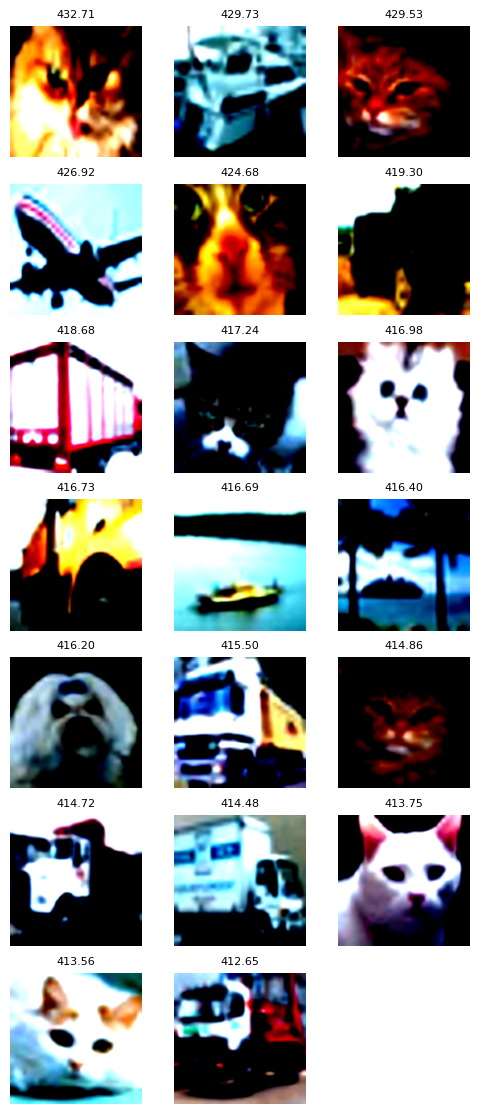

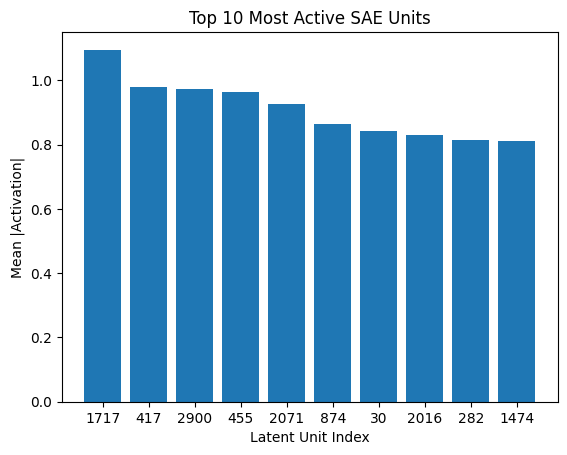

In [ ]:
subset_size = len(train_dataset) // 10
indices = list(range(subset_size))
subset = Subset(train_dataset, indices)
top_imgs, top_scores, top_unit_vals, top_unit_idx = top_k_images(sae_vit, subset, vit_device, k=20, batch_size=20)
show_image_grid(top_imgs, titles=top_scores.tolist(), nrow=3)
show_active_units(top_unit_vals, top_unit_idx)